## Import Resources

In [60]:
# Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

tfds.disable_progress_bar()

In [61]:
# Make all other necessary imports.

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import json

### Print out the versions of the libs being used

In [62]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)

Using:
	• TensorFlow version: 2.18.0
	• tf.keras version: 3.6.0


## Load the Dataset

Here we'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  We'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the MobileNet pre-trained network that we will use later.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but we'll still need to normalize and resize the images to the appropriate size for inference.

In [63]:
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [64]:
# Create a training set, a validation set and a test set.

# Since the size of the test set is larger than the training, we have mapped the test_set to be used for model
# training and the training_set be used for evaluation

training_set = dataset['test']
validation_set = dataset['validation']
test_set = dataset['train']

## Explore the Dataset

In [65]:
# Get the number of examples in each set from the dataset info.

num_training = dataset_info.splits['test'].num_examples
num_validation = dataset_info.splits['validation'].num_examples
num_test = dataset_info.splits['train'].num_examples

print('Number of training examples: ', num_training)
print('Number of validation examples: ', num_validation)
print('Number of testing examples: ', num_test)


# Get the number of classes in the dataset from the dataset info.

num_classes = dataset_info.features['label'].num_classes
print('Number of Classes: ', num_classes)

Number of training examples:  6149
Number of validation examples:  1020
Number of testing examples:  1020
Number of Classes:  102


In [66]:
# Print the shape and corresponding label of 3 images in the training set.

i = 0
for image, label in training_set.take(3):
    print('Shape of Image ', i + 1, '::')
    print(image.numpy().shape)
    print('Label: ', label.numpy())
    print('\n')
    i += 1

Shape of Image  1 ::
(542, 500, 3)
Label:  40


Shape of Image  2 ::
(748, 500, 3)
Label:  76


Shape of Image  3 ::
(500, 600, 3)
Label:  42




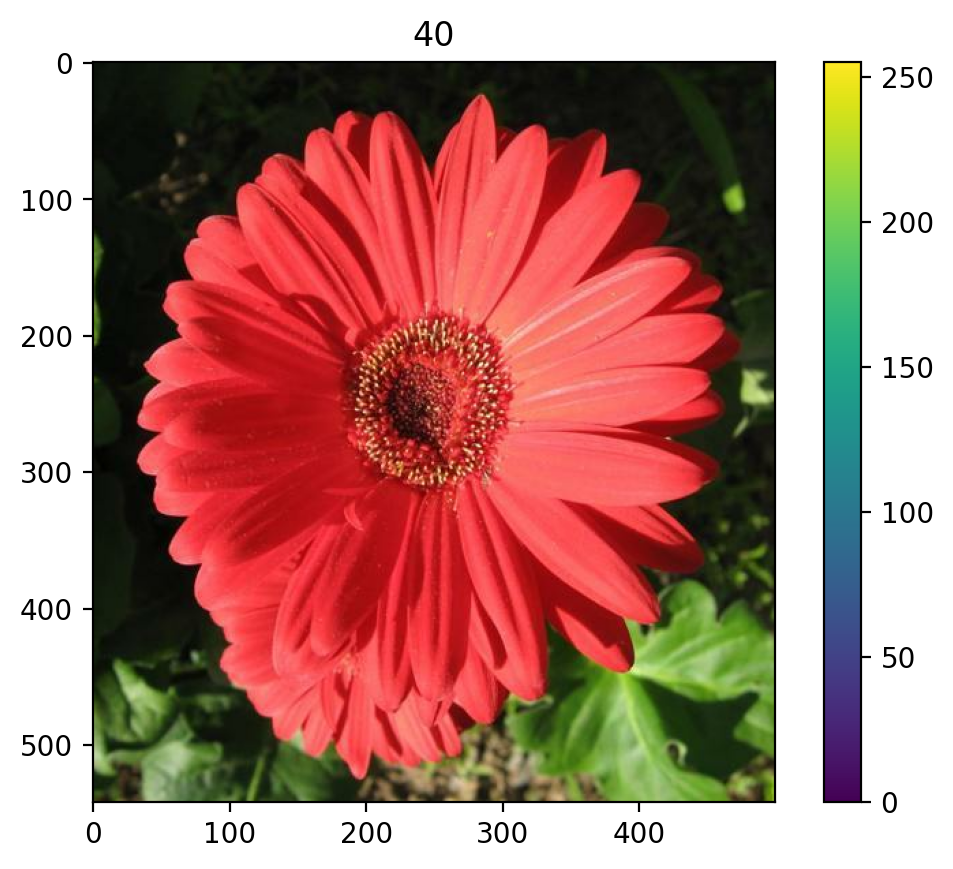

In [67]:
# Plot 1 image from the training set. Set the title of the plot to the corresponding image label.

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image)
plt.colorbar()
plt.title(label)
plt.show()

### Label Mapping

We'll need to load in a mapping from label to category name. We can find this in the file `label_map.json` that comes along with the dataset. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give us a dictionary mapping the integer coded labels to the actual names of the flowers.

In [68]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [69]:
# Normalize the images to proper sizes

def image_normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.image.resize(image, [224, 224])
    return image, label

training_set = training_set.map(image_normalize)
validation_set = validation_set.map(image_normalize)
test_set = test_set.map(image_normalize)

training_set, validation_set, test_set

(<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

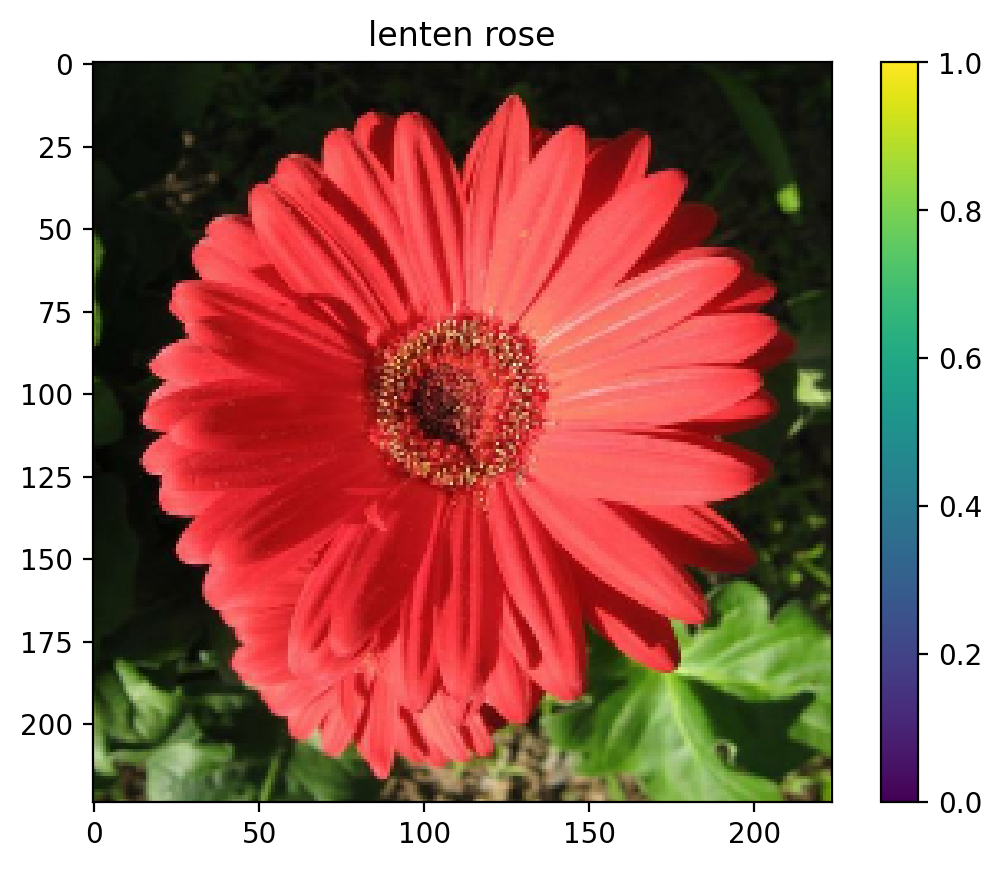

In [70]:
# Plot 1 image from the training set. Set the title of the plot to the
# corresponding class name.

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image)
plt.colorbar()
plt.title(class_names[str(label)])
plt.show()

## Create Pipeline

In [71]:
# Create a pipeline for each set.

batch_size = 51

training_batches = training_set.cache().shuffle(num_training // 4).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).prefetch(1)

## MobileNet Pretrained Model and Accuracy checking

In [72]:
import tensorflow as tf

# Load the MobileNetV2 pre-trained model from Keras, excluding the top layer (no classification head)
feature_extractor = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the final classification layer
    weights='imagenet'  # Use pre-trained weights
)

# Freeze the MobileNetV2 layers to prevent them from being trained
feature_extractor.trainable = False

# Define the model using Functional API to ensure proper input-output handling
inputs = tf.keras.Input(shape=(224, 224, 3))  # Specify input shape explicitly
x = feature_extractor(inputs, training=False)  # Call the feature extractor on the input
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Apply global average pooling
x = tf.keras.layers.Dense(102, activation='softmax')(x)  # Output layer for 102 classes

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=x)

# Print model summary to check its structure
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Assuming training_batches and validation_batches are defined and preprocessed, fit the model
history = model.fit(
    training_batches,
    epochs=10,  # Set the number of epochs as needed
    validation_data=validation_batches
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 61s 480ms/step - accuracy: 0.3185 - loss: 3.3134 - val_accuracy: 0.7020 - val_loss: 1.3101
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 392ms/step - accuracy: 0.8559 - loss: 0.7950 - val_accuracy: 0.8157 - val_loss: 0.8056
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 416ms/step - accuracy: 0.9282 - loss: 0.4334 - val_accuracy: 0.8569 - val_loss: 0.6414
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 395ms/step - accuracy: 0.9581 - loss: 0.2959 - val_accuracy: 0.8735 - val_loss: 0.5647
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 49s 409ms/step - accuracy: 0.9755 - loss: 0.2119 - val_accuracy: 0.8833 - val_loss: 0.5057
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 422ms/step - accuracy: 0.9849 - loss: 0.1680 - val_accuracy: 0.8755 - val_loss: 0.4863
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 56s 465ms/step - accuracy: 0.9889 - loss: 0.1312 - val_accuracy: 0.8961 - val_loss: 0.4402
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 59s 488ms/step - accuracy: 0.9952 - loss: 0

In [73]:
# Train the Network

history = model.fit(training_batches,
                    epochs = 10,
                    validation_data = validation_batches)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 59s 484ms/step - accuracy: 0.9982 - loss: 0.0608 - val_accuracy: 0.9010 - val_loss: 0.4058
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 59s 485ms/step - accuracy: 0.9991 - loss: 0.0507 - val_accuracy: 0.8990 - val_loss: 0.4023
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 59s 485ms/step - accuracy: 0.9998 - loss: 0.0437 - val_accuracy: 0.8951 - val_loss: 0.3954
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9998 - loss: 0.0373 - val_accuracy: 0.9010 - val_loss: 0.3843
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 398ms/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 0.9010 - val_loss: 0.3892
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 420ms/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 0.9049 - val_loss: 0.3744
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 59s 486ms/step - accuracy: 1.0000 - loss: 0.0268 - val_accuracy: 0.9088 - val_loss: 0.3686
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 67s 553ms/step - accuracy: 1.0000 - loss: 0.0

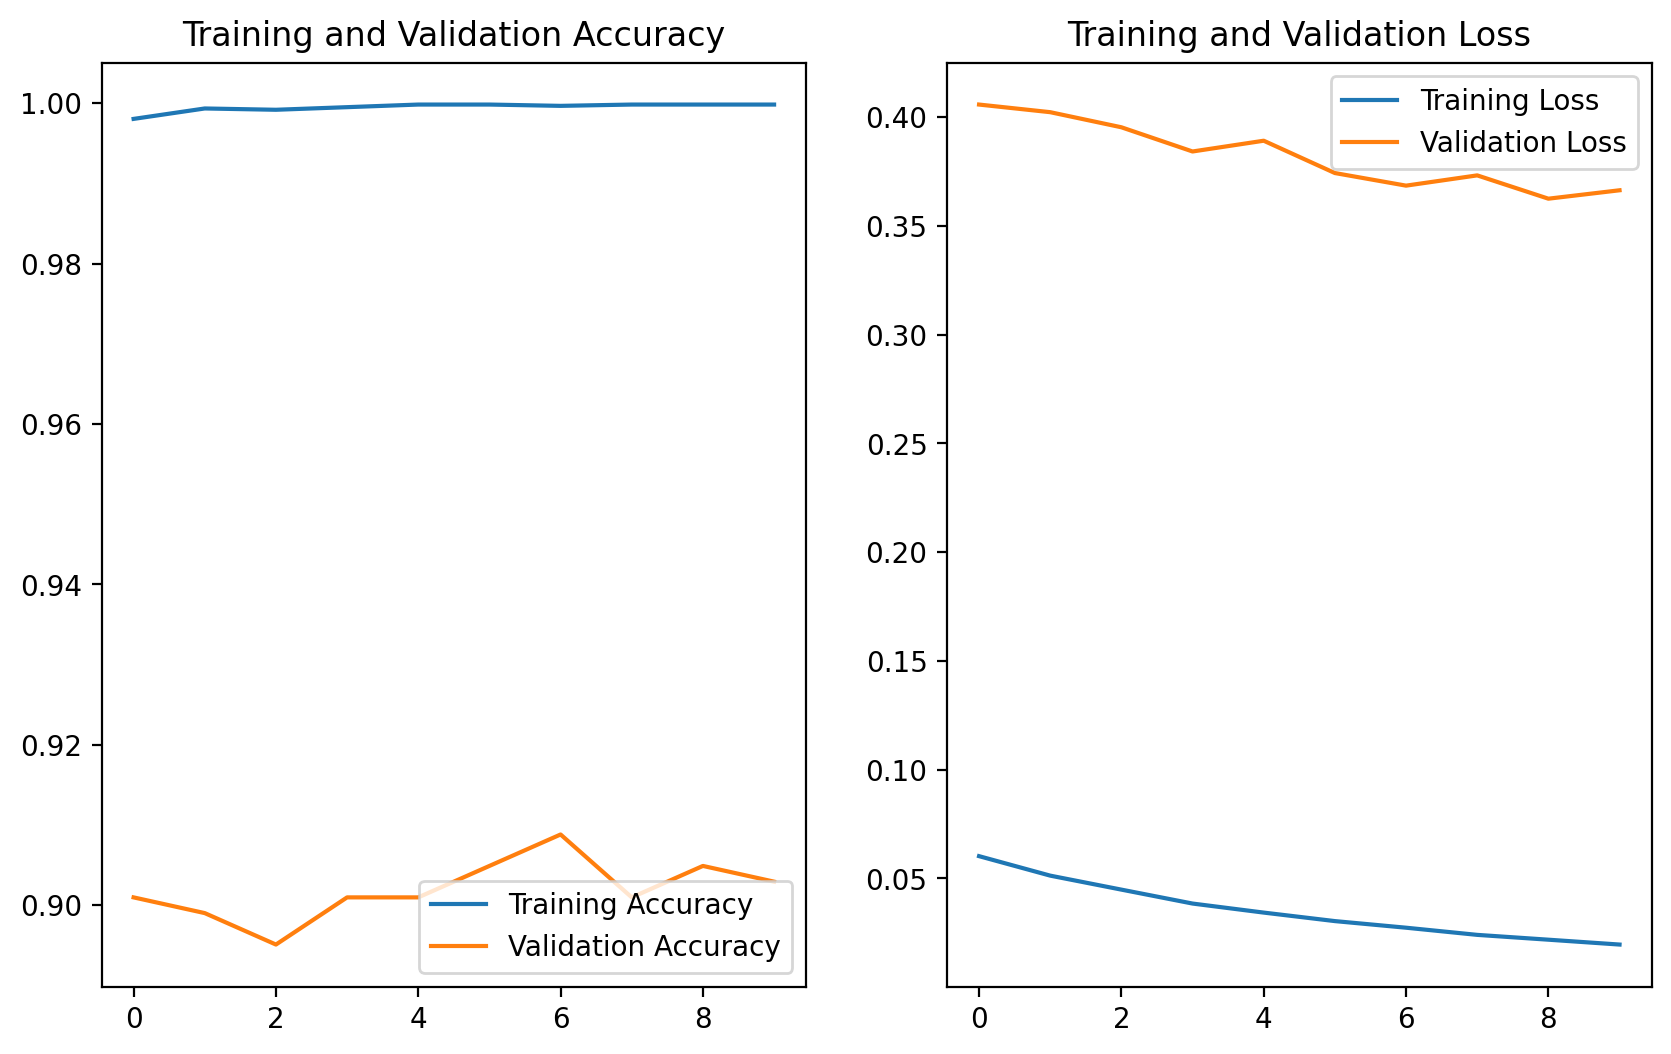

In [74]:
# Plot the loss and accuracy values achieved during training for the training
# and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## Testing the Network

In [75]:
# Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(testing_batches)

print('Loss of the model on testing set: ', loss * 100)
print('Accuracy of model on testing set: ', accuracy * 100)

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 547ms/step - accuracy: 0.8775 - loss: 0.4642
Loss of the model on testing set:  44.426628947257996
Accuracy of model on testing set:  88.33333253860474


## Save the Model

We will now save the model so we can load it later for making inference. We will save our model as a Keras 'HD5' model file.

In [76]:
# Save the trained model as a Keras model.

saved_keras_model_filepath = './Oxford_Flowers102_model_MobileNet.h5'

model.save(saved_keras_model_filepath)

## Load the Keras Model

Load the Keras model we saved above.

In [77]:
# Load the Keras model

reloaded_model = tf.keras.models.load_model(saved_keras_model_filepath,
                                            custom_objects = {'KerasLayer': hub.KerasLayer})

reloaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,648 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [78]:
# Create the process_image function

def process_image(image_array):
    image_tensor = tf.convert_to_tensor(np.array(image_array))
    image_tensor = tf.cast(image_tensor, tf.float32)
    image_tensor /= 255
    image_tensor = tf.image.resize(image_tensor, [224, 224])
    return image_tensor.numpy()


### Testing our `process_image` function:

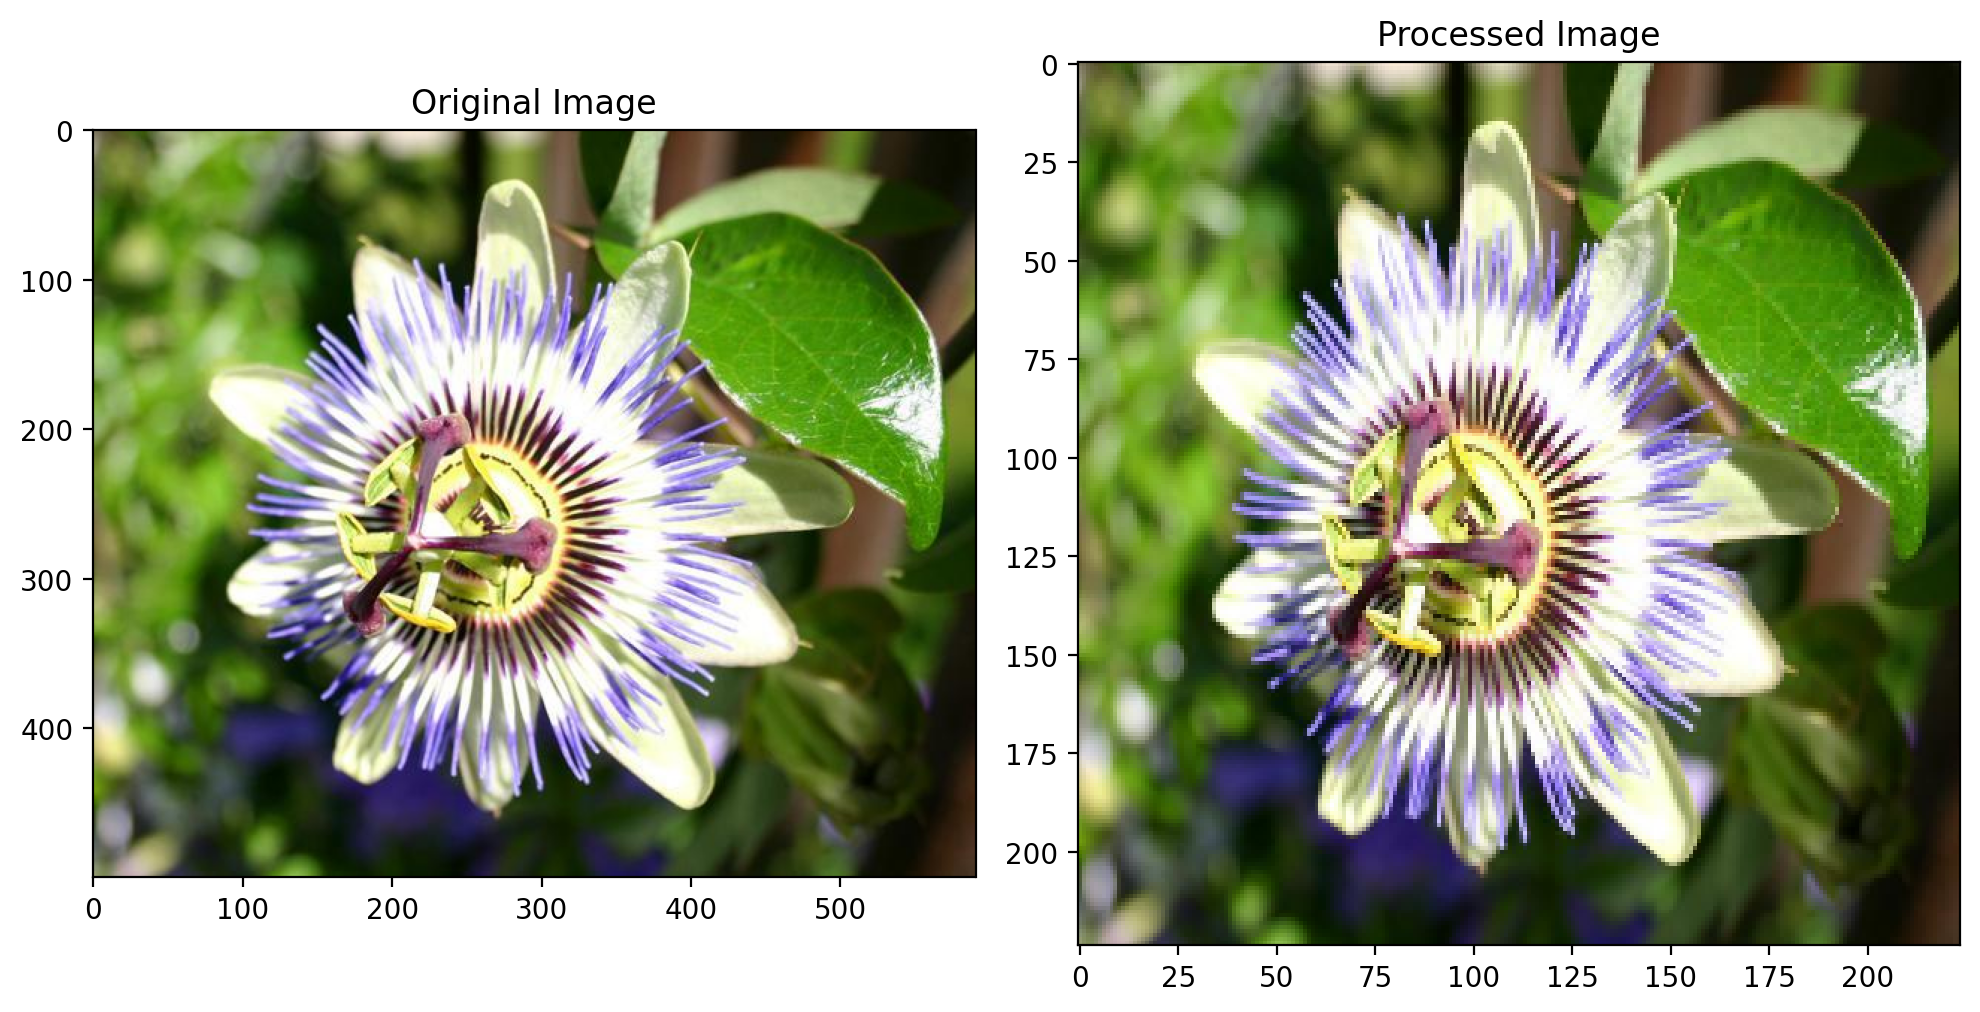

In [79]:
from PIL import Image

image_path = '/Users/manaspurohit/Documents/Coding/Machine Learning /Dataset/image_00001.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [80]:
# Create the predict function

def predict(image_path, model, top_k):
    from PIL import Image

    img = Image.open(image_path)
    test_image = np.asarray(img)

    processed_image = process_image(test_image)
    processed_image = np.expand_dims(processed_image, axis = 0)

    reloaded_model = tf.keras.models.load_model(model,
                                                custom_objects = {'KerasLayer': hub.KerasLayer})

    img_prob = reloaded_model.predict(processed_image)

    return -np.sort(-img_prob)[:, :int(top_k)], np.argsort(-img_prob)[:, :int(top_k)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


Text(0.5, 1.0, 'Class Proability Distribution')

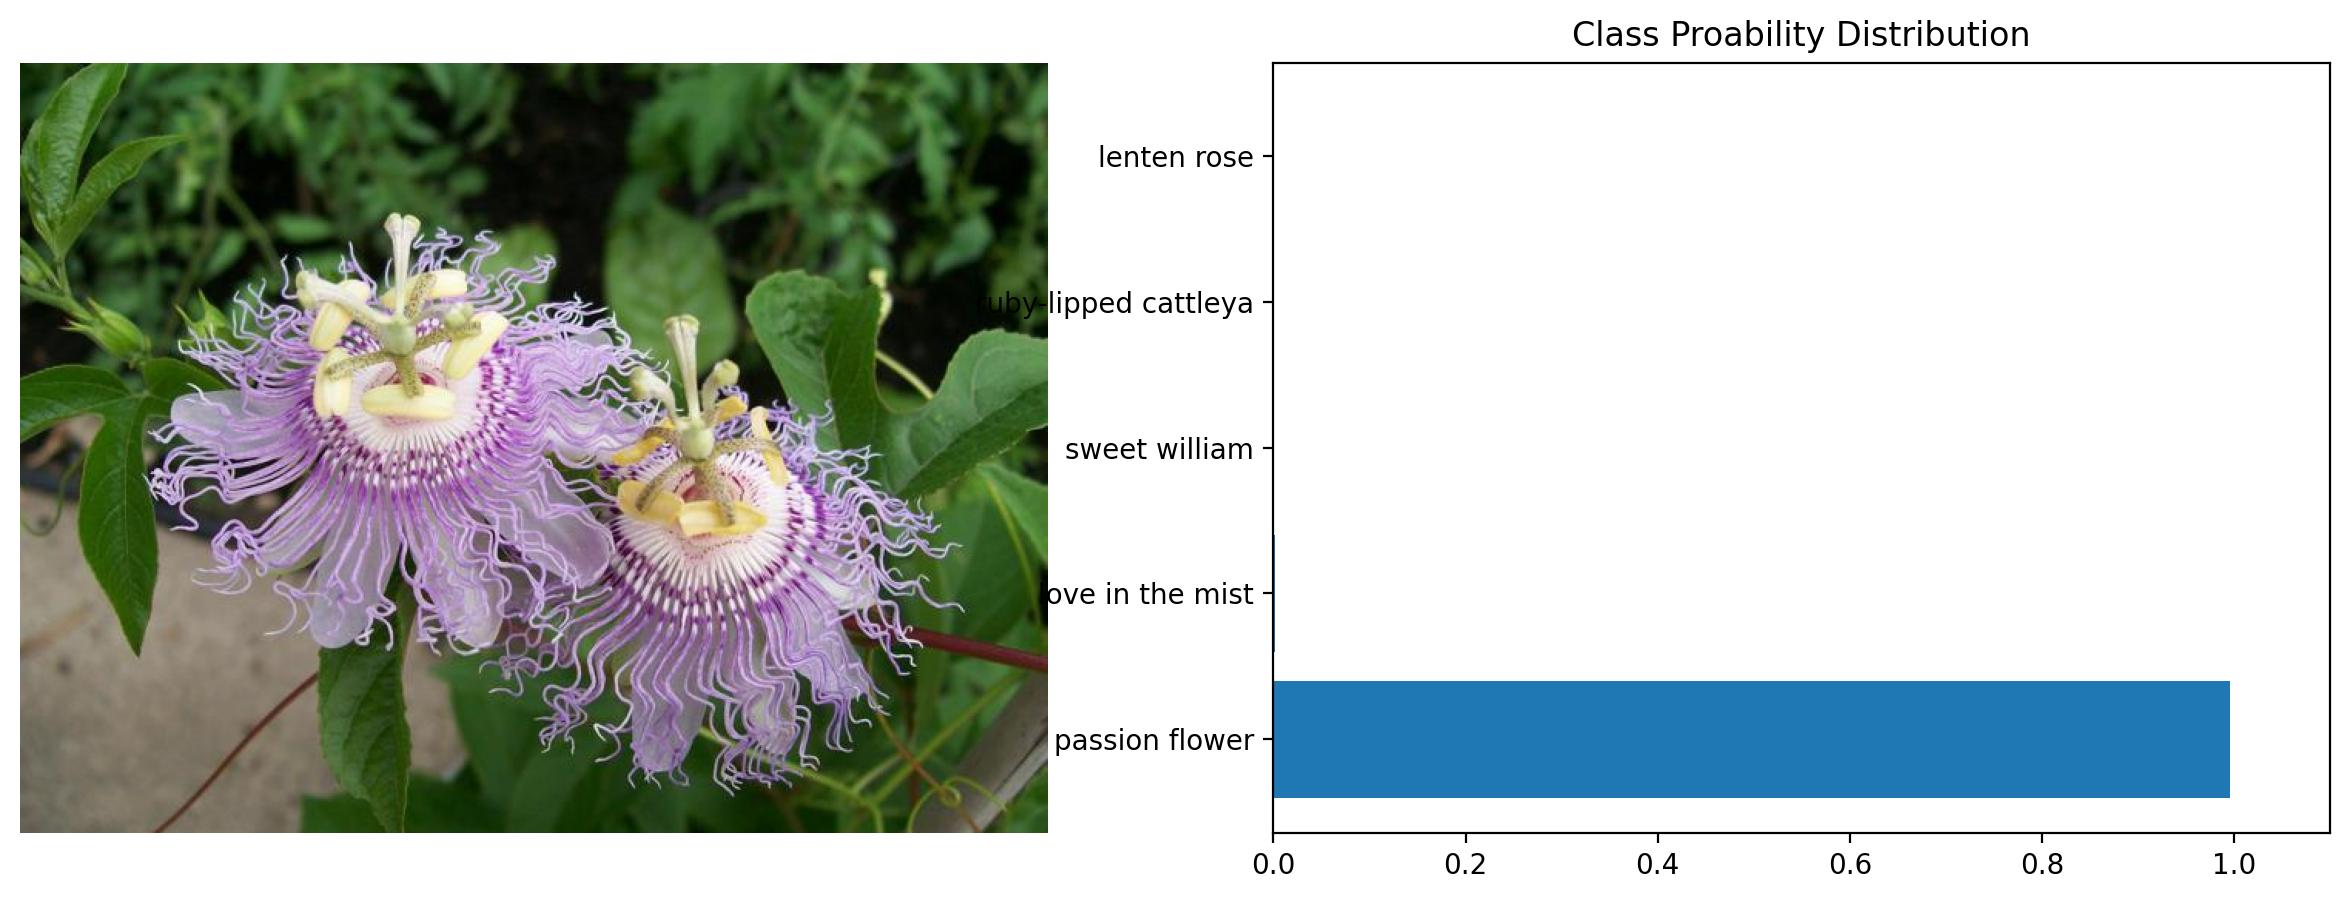

In [81]:
# Plot the input image along with the top 5 classes

image_path = 'Dataset/image_00189.jpg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path,
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


Text(0.5, 1.0, 'Class Proability Distribution')

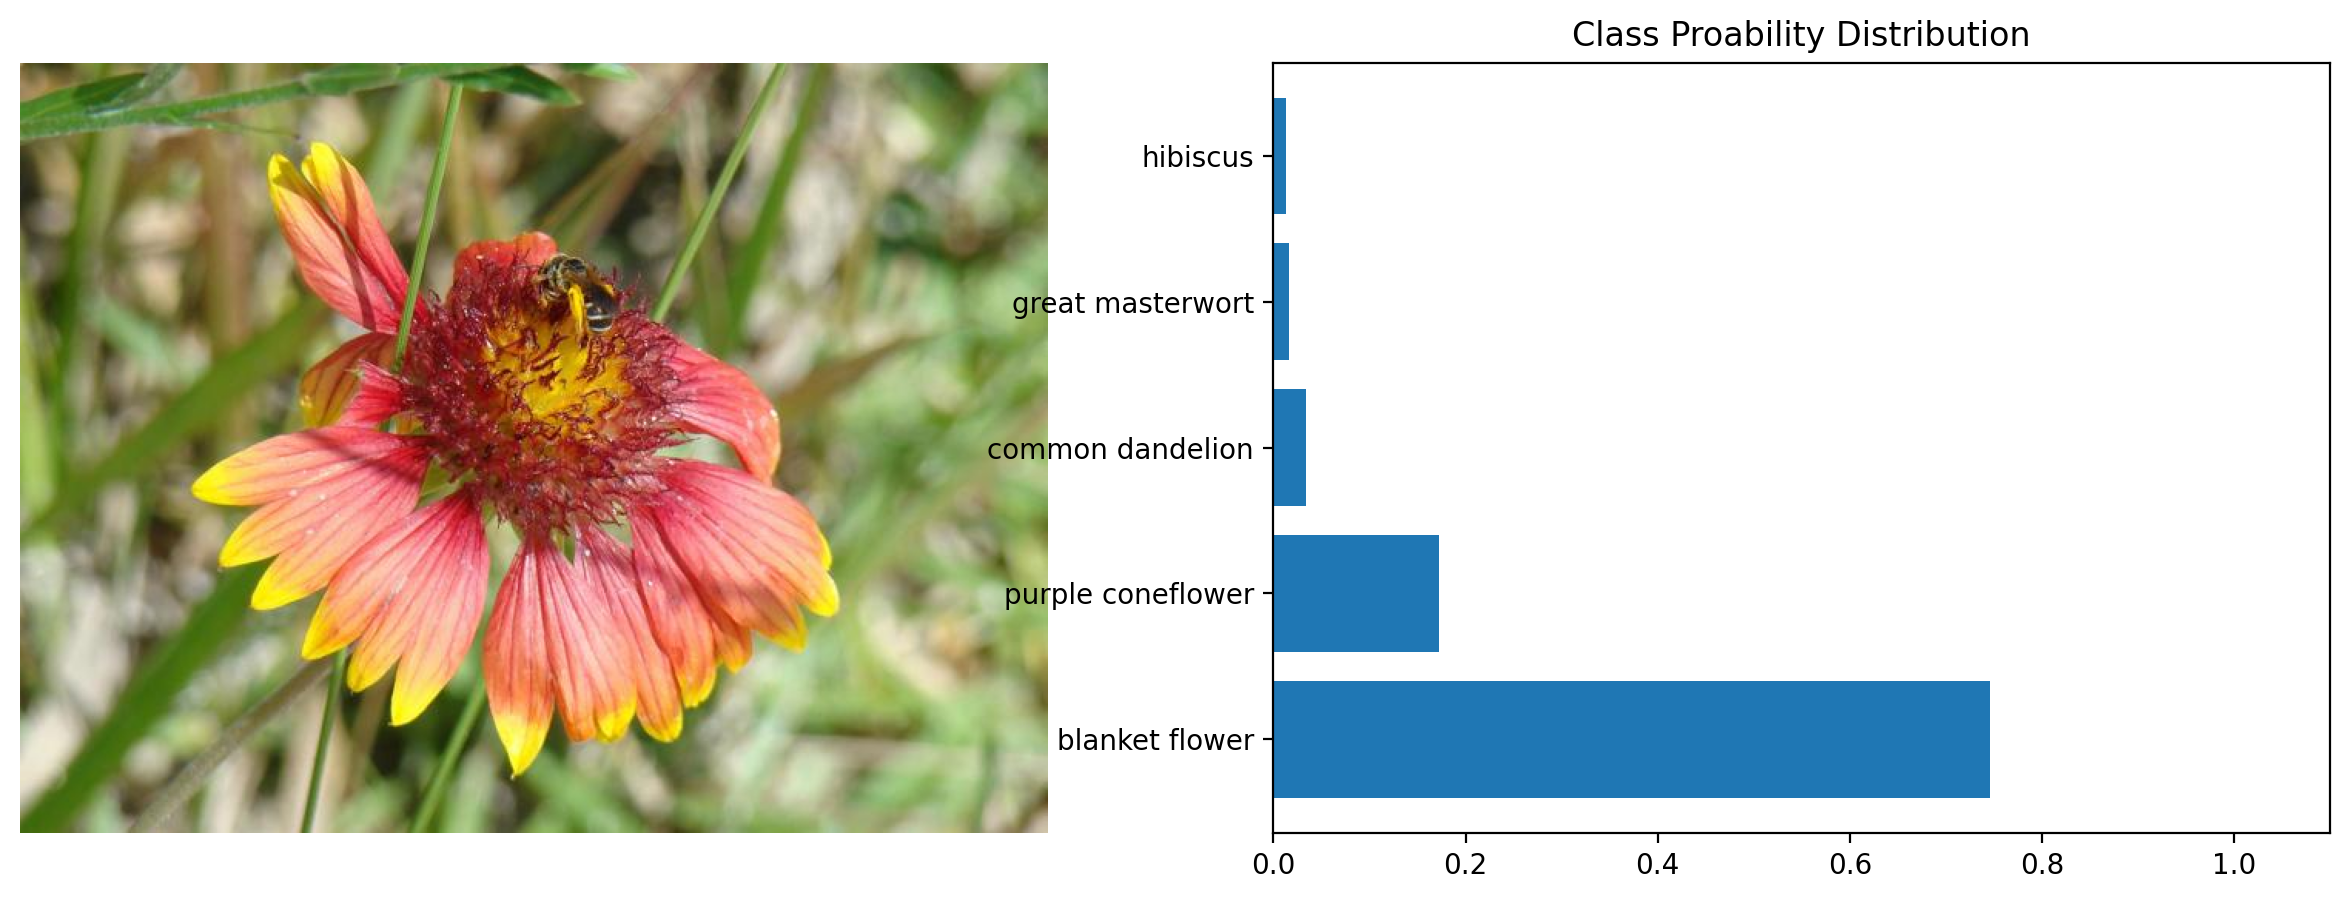

In [82]:
image_path = 'Dataset/image_07902.jpg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path,
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


Text(0.5, 1.0, 'Class Proability Distribution')

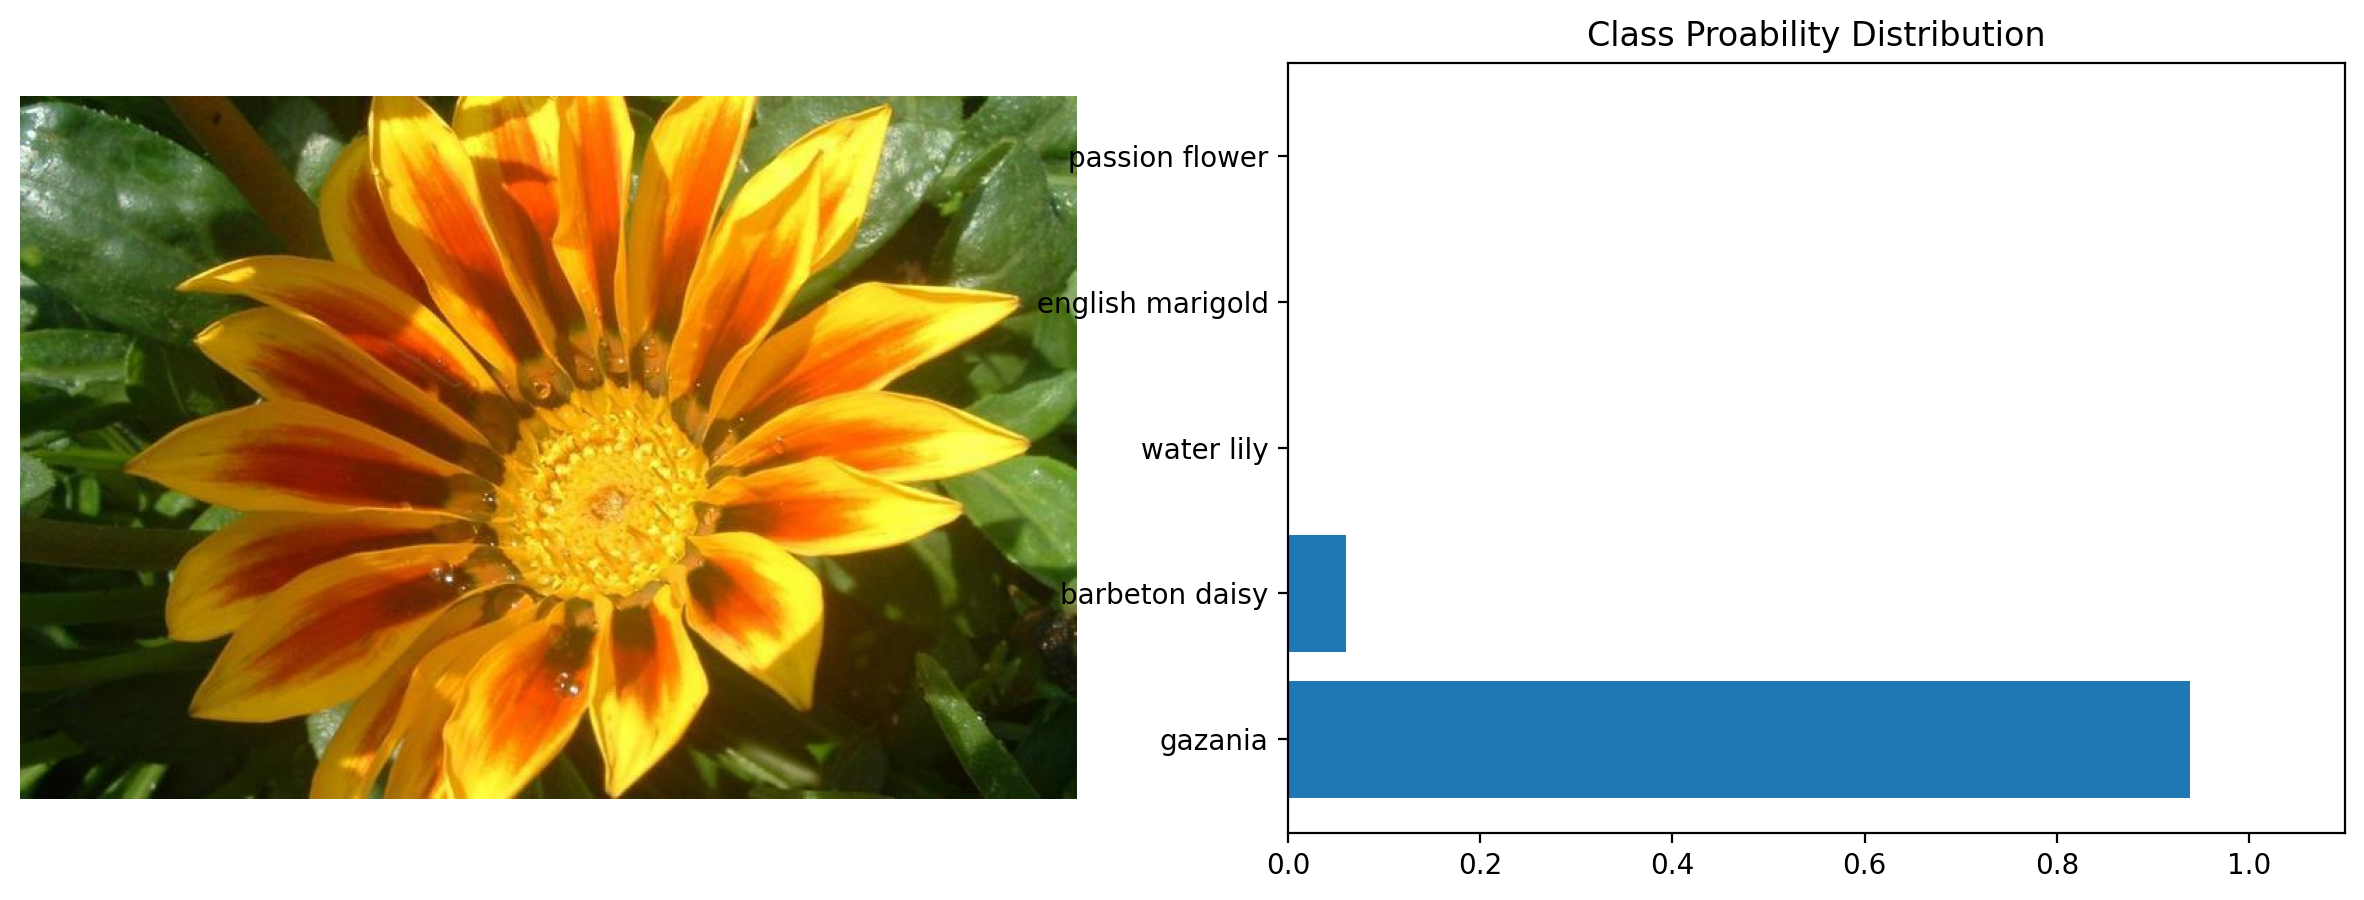

In [83]:
image_path = 'Dataset/image_04526.jpg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path,
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


Text(0.5, 1.0, 'Class Proability Distribution')

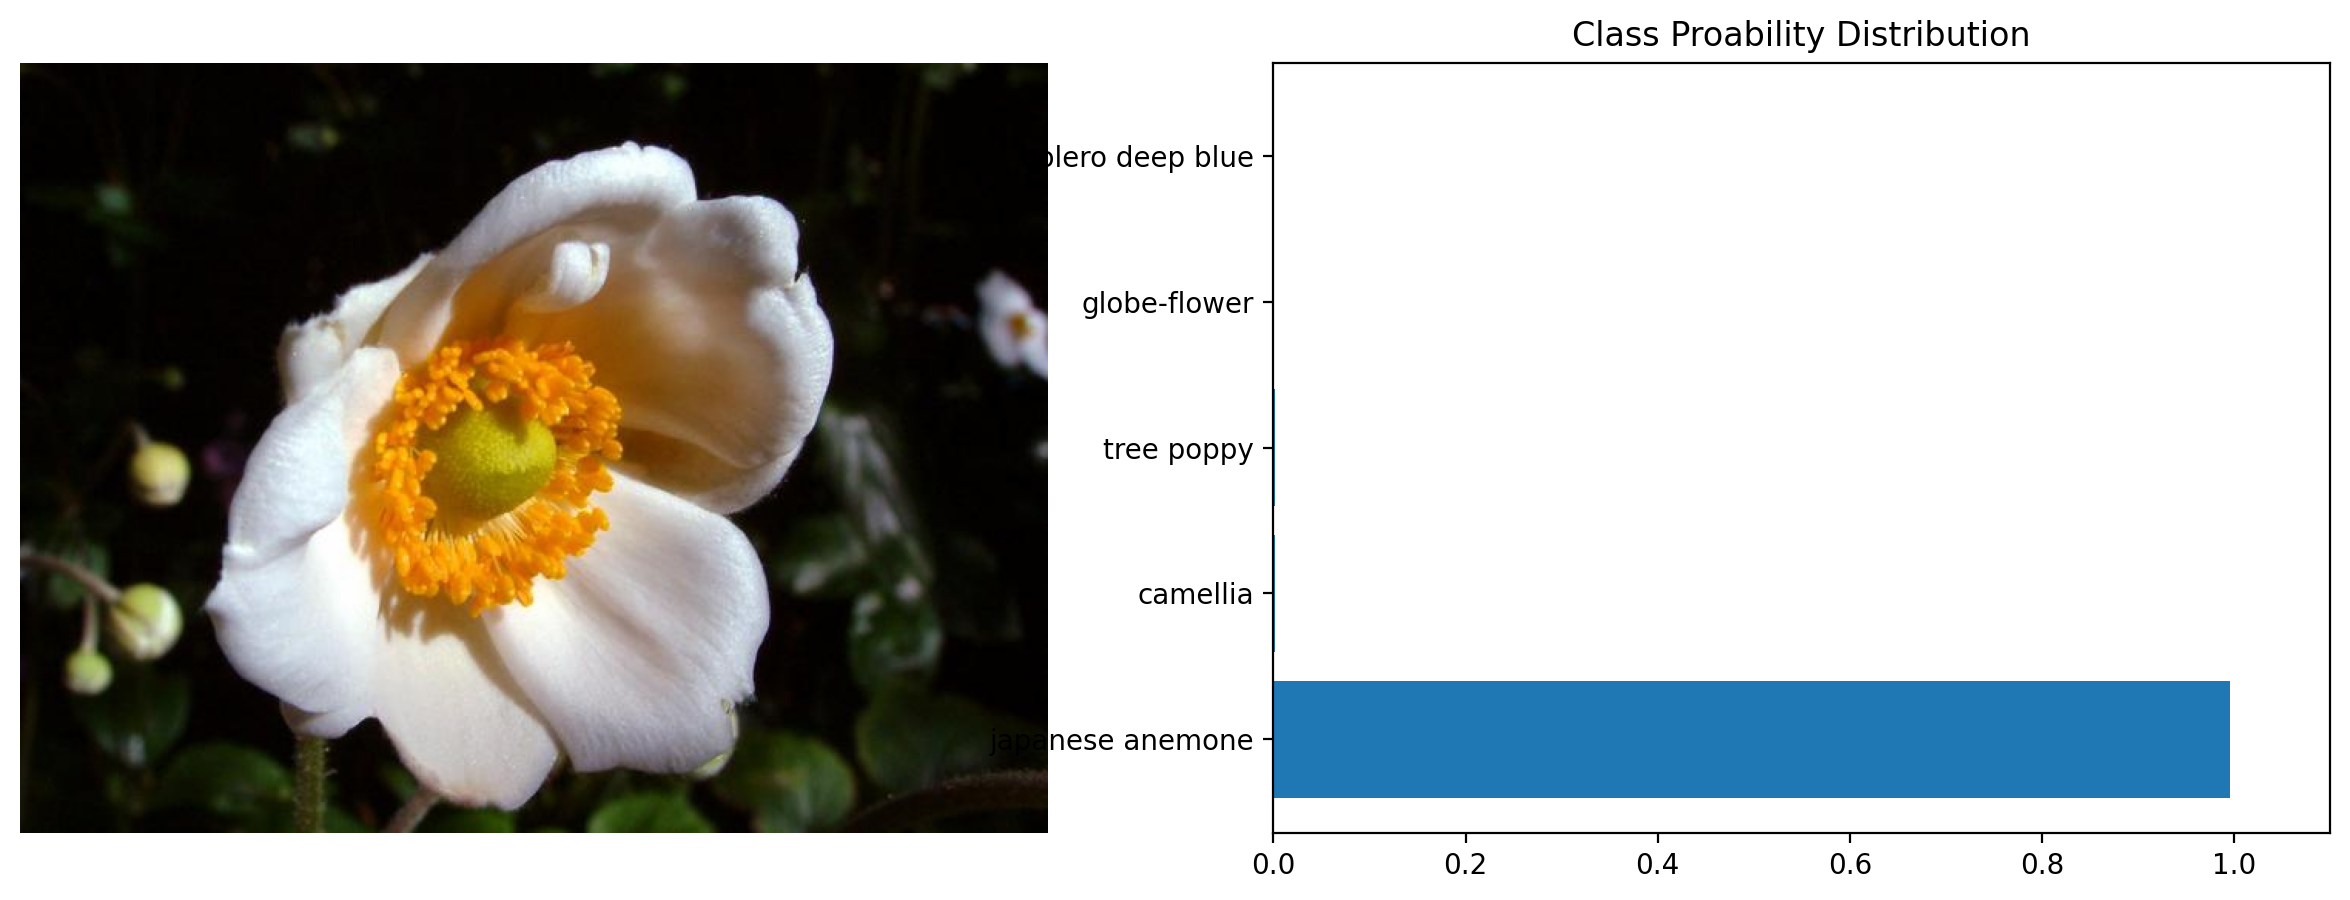

In [84]:
image_path = 'Dataset/image_08189.jpg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path,
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


Text(0.5, 1.0, 'Class Proability Distribution')

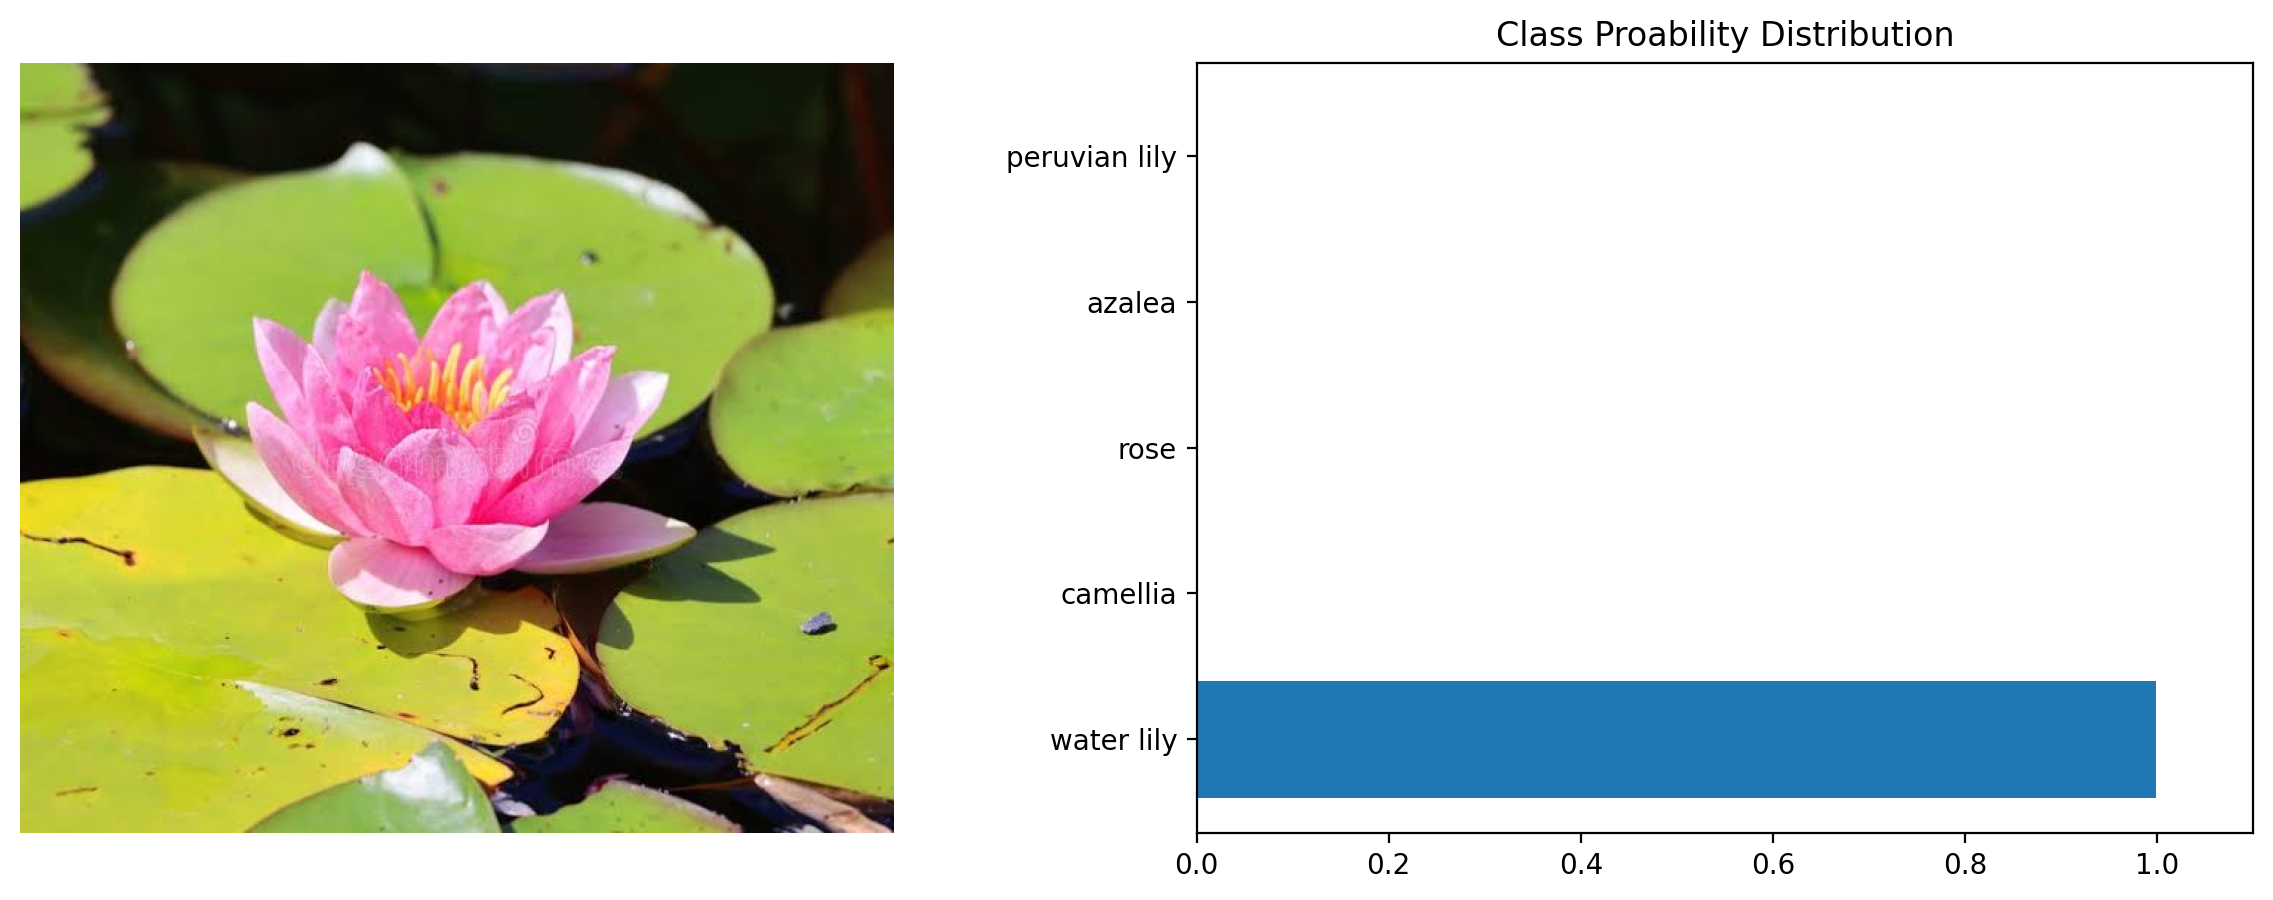

In [85]:
image_path = '/Users/manaspurohit/Downloads/Flowers/images (1).jpeg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path,
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')